In this file i try to predict names of people that are being shown on the photos using  
PCA preprocessing, and then SVC and RandomForestClassifier models.

In [1]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

In [2]:
print("Shape of images: " + str(faces.images.shape))
print("Target people:\n " + str(faces.target_names))

Shape of images: (1348, 62, 47)
Target people:
 ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

Examples of photos on which I am working: 


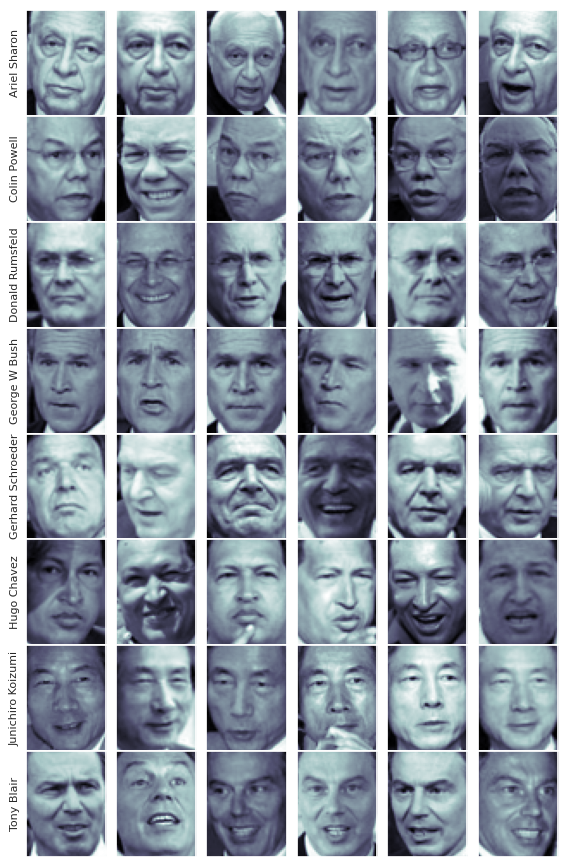

In [4]:
#Plotting example photos
# Create subplots for the images
fig, ax = plt.subplots(len(faces.target_names), 6, figsize=(7, 11))
fig.subplots_adjust(hspace=0, wspace=0)

print("Examples of photos on which I am working: ")

for j in range(len(faces.target_names)):
    for i in range(6):
        ax[j, 0].set_ylabel(faces.target_names[j],fontsize=8)
        # Remove both x and y ticks
        ax[j, i].xaxis.set_major_locator(plt.NullLocator())
        ax[j, i].yaxis.set_major_locator(plt.NullLocator())
        ax[j, i].imshow(faces.images[faces.target == j][i], cmap="bone")

plt.show()

Since those pictures have 62x47 pixels it means that to describe those faces 
we need almost 3000 independent numbers (dimensions)!

To make it easier I am going to reduce the number of dimensions with the help of the PCA alghoritm.

Text(0.5, 1.0, 'dependence of the culminative explained variance\n on number of PCA components')

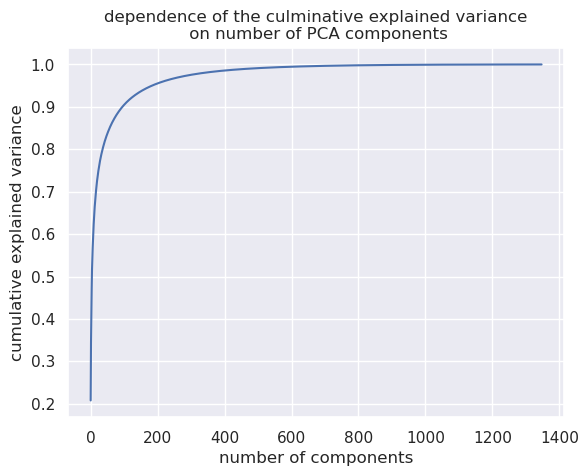

In [17]:
from sklearn.decomposition import PCA
pca = PCA().fit(faces.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("dependence of the culminative explained variance\n on number of PCA components")

Culminative explained variance could be thought of as amount of information  
contained with relation to orginal data. Crearly if we use 200 components it should be enough!

In [6]:
#preparing test and evaluation datasets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
random_state=22)

In [7]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

#set up the model and pipeline
svc = SVC(kernel='rbf', class_weight='balanced') #balanced so that frequency of different classes wontbe afecting the model too much
pca = PCA(n_components=200, svd_solver='randomized', whiten=True, random_state=2)

#create pipeline
model = make_pipeline(pca, svc)

In [8]:
#Looking for the best hyperparams using gridsearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1,3,5,7,15,50]}
grid = GridSearchCV(model,param_grid)
grid.fit(Xtrain, ytrain)

GridSearchCV(estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=200, random_state=2,
                                            svd_solver='randomized',
                                            whiten=True)),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [1, 3, 5, 7, 15, 50]})

In [9]:
print("Best value of C found by GridSearchCV: \n")
print(grid.best_params_)

Best value of C found by GridSearchCV: 

{'svc__C': 5}


In [10]:
#predict on the test set
model = grid.best_estimator_
yfit = model.predict(Xtest)

Lets evaluate how SVC performs on this dataset

In [11]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.59      0.74        17
     Colin Powell       0.83      0.84      0.84        58
  Donald Rumsfeld       0.95      0.61      0.75        31
    George W Bush       0.72      1.00      0.84       129
Gerhard Schroeder       0.93      0.76      0.84        34
      Hugo Chavez       1.00      0.43      0.60        21
Junichiro Koizumi       1.00      0.62      0.76        13
       Tony Blair       0.96      0.68      0.79        34

         accuracy                           0.81       337
        macro avg       0.92      0.69      0.77       337
     weighted avg       0.85      0.81      0.80       337



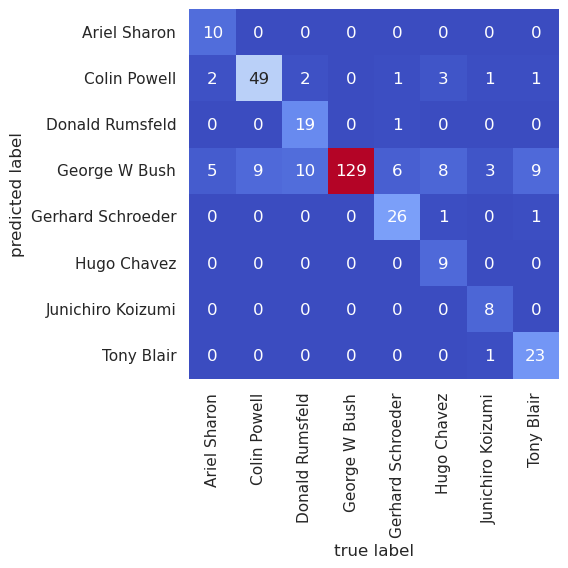

In [18]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,yticklabels=faces.target_names, cmap='coolwarm')
plt.xlabel('true label')
plt.ylabel('predicted label');

This picture explaines how many times SVC predicted the label good and how many times it made a mistake.  
Here George W Bush wasn't confused by the model at all(maybe because this data set  
contains relativly big number of photos of him) but Schroeder was confused 6 times with George.

So given all that SVC model does a pretty good job, but i will also try to do it with 
RandomTree model and then see which model is performing better


In [13]:
from sklearn.ensemble import RandomForestClassifier

rca = RandomForestClassifier(n_estimators=200, random_state=0)
model2 = rca.fit(Xtrain,ytrain)

In [14]:
yfit2 = model2.predict(Xtest)

In [15]:
#evaluate the model
print(classification_report(ytest, yfit2,target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.12      0.21        17
     Colin Powell       0.67      0.78      0.72        58
  Donald Rumsfeld       0.75      0.19      0.31        31
    George W Bush       0.55      0.98      0.70       129
Gerhard Schroeder       0.71      0.15      0.24        34
      Hugo Chavez       1.00      0.24      0.38        21
Junichiro Koizumi       1.00      0.23      0.38        13
       Tony Blair       0.75      0.35      0.48        34

         accuracy                           0.61       337
        macro avg       0.80      0.38      0.43       337
     weighted avg       0.69      0.61      0.54       337



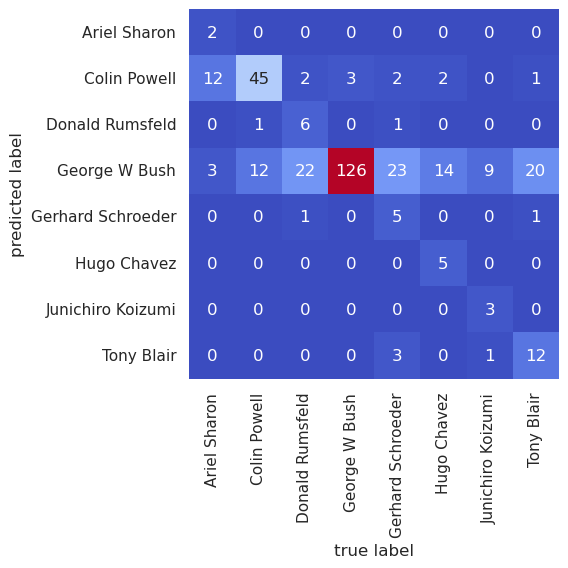

In [16]:
mat = confusion_matrix(ytest, yfit2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,yticklabels=faces.target_names, cmap='coolwarm')
plt.xlabel('true label')
plt.ylabel('predicted label');


So SVC performs much more better than RandomTree in that case!